# **Keras custom series-train_step method用法**  
之前提到，若要自訂義訓練可以使用`tf.GradientTap()`方式，但是很多keras的高階API就無法使用，所以在TensorFlow 2.2以上的版本提供了自定義訓練並且可以同時使用高階API的方法：**`train_step`** 。  
本次使用修改的DCGAN來當作例子，GAN是一種unsupervised learning方法，主要由兩個部分構成：  
+ generator：經由noise生成目標所需的物件的model。  
+ discriminator：判斷fake與true的model。  
透過這兩個model之間的交互訓練，最終讓generator model生成出的物件與真實物件相同，就是GAN的主要想法。

In [1]:
#載入所需lib
import numpy as np
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print('TensorFlow version:', tf.__version__)
#畫圖的lib
import matplotlib.pyplot as plt
import math

TensorFlow version: 2.2.0


## **建立GAN model**

### generator model：  
從noise生成影像的model。

In [2]:
def build_generator(latent_dim=100):
    inputs = tf.keras.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(7*7*128)(inputs)
    x = tf.keras.layers.Reshape((7, 7, 128))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(128, 5, 2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(64, 5, 2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(32, 5, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(1, 5, padding='same', activation='sigmoid')(x)
    
    generator = tf.keras.Model(inputs, x, name='generator')
    return generator

### discriminator model：
用來判別影像是真實(real)或者偽造(fake)。

In [3]:
def build_discriminator():
    inputs = tf.keras.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(32, 5, 2, padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv2D(64, 5, 2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv2D(128, 5, 2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv2D(256, 5, padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    discriminator = tf.keras.Model(inputs, x, name='discriminator')
    return discriminator

## **自定義Model class**  
修改Model中的一些相關method(`__init__`、`train_step`、`compile`)來自定義訓練以及享有`fit()` method。

In [4]:
class DCGAN(tf.keras.Model):
    # 初始設定兩個model
    def __init__(self, discriminator, generator):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        
    # 設定兩個model的optimizer
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
    
    # 自定義訓練
    def train_step(self, data):
        # data是fit中input data的組合，將images取出，images shape應該為(batch_size, h, w, 1)
        images = data[0]
        
        # random noise
        batch_size = tf.shape(images)[0]
        random_noise = tf.random.normal(shape=(batch_size, 100))
        
        # 由generator生成影像
        fake_images = self.generator(random_noise, training=False)
        # 與real image合併
        comb_images = tf.concat([images, fake_images], axis=0)
        # 給予label(real images給1、fake images給0)，用來訓練discriminator
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # 給label一些noise
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        labels = tf.clip_by_value(labels, 0, 1)
        
        
        # 使用tf.GradientTape訓練discriminator
        with tf.GradientTape() as tape:
            dis_pred = self.discriminator(comb_images, training=True)
            d_loss = self.loss_fn(labels, dis_pred)
        pred_grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(pred_grads, self.discriminator.trainable_weights))
        
        # 由random noise生成影像
        random_noise = tf.random.normal(shape=(batch_size, 100))
        # 生成的影像給予1，透過損失調整generator
        fake_labels = tf.ones((batch_size, 1))
        
        # 使用tf.GradientTape訓練generator
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_noise, training=True)
            pred = self.discriminator(fake_images, training=False)
            g_loss = self.loss_fn(fake_labels, pred)
        g_grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_weights))
        
        return {'d_loss': d_loss, 'g_loss': g_loss}

## **建立觀察影像結果的callbacks**  
除了根據loss可以觀察model的狀態，這邊自定義一個callbacks來儲存指定epoch的結果。
自定義callbacks詳細資訊查閱[Writing your own callbacks](https://keras.io/guides/writing_your_own_callbacks/)。

In [5]:
class save_result(tf.keras.callbacks.Callback):
    
    # 初始化依些需要的參數(ex:input noise、間隔多少epoch存圖像結果等等參數)
    def __init__(self, data=None, save_freq=None, save_path=None):
        super(save_result, self).__init__()
        self.data = data
        self.save_freq = save_freq
        self.save_path = save_path
    
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            result = self.model.generator(self.data, training=False)
            plt.figure(figsize=(5, 5))
            plt.suptitle('{:04d}_epoch'.format(epoch + 1))
            plt.subplots_adjust(wspace=0, hspace=0)
            for i, images in enumerate(result):
                images = tf.reshape(images, (28, 28))
                plt.subplot(5, 5, i+1)
                plt.imshow(images, cmap='gray')
                plt.axis('off')
            plt.savefig(self.save_path + '{:04d}_epoch'.format(epoch + 1) + '.png')

In [6]:
#download MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
total_data = np.concatenate([x_train, x_test], axis=0)

# 觀察用的noise
noise = np.random.normal(size=(25, 100))
img_log = save_result(noise, 5, './ch9/')

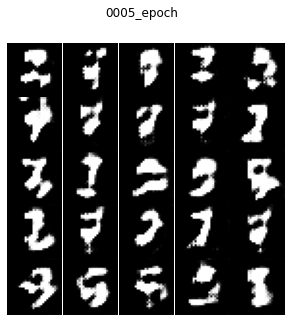

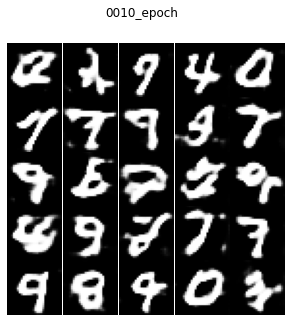

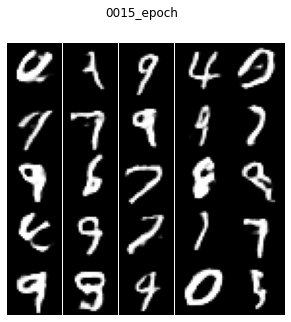

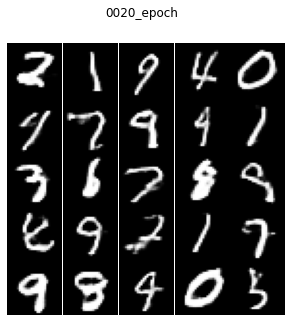

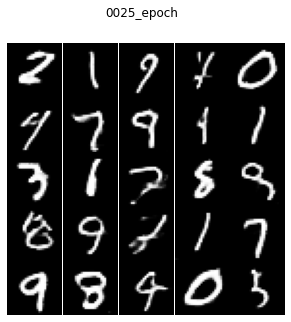

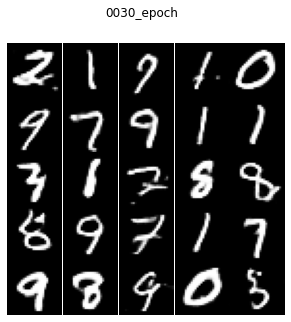

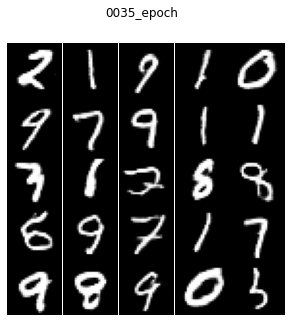

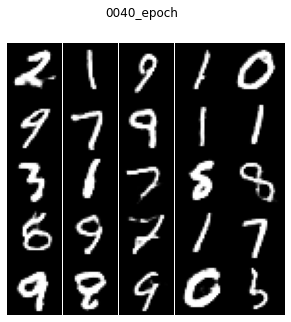

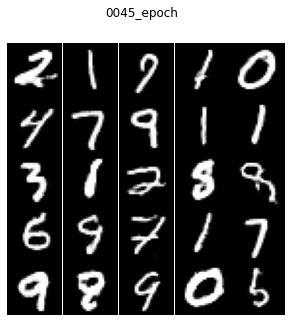

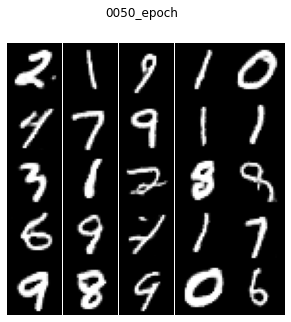

In [7]:
discriminator = build_discriminator()
generator = build_generator()
dcgan = DCGAN(discriminator=discriminator, generator=generator)
dcgan.compile(
    d_optimizer=tf.keras.optimizers.Adam(0.0003),
    g_optimizer=tf.keras.optimizers.Adam(0.0003),
    loss_fn=tf.keras.losses.BinaryCrossentropy()
)
dcgan.fit(total_data, epochs=50, batch_size=128, callbacks=[img_log], verbose=0)

## **總結**  
修改了`train_step`自定義訓練訓並且使用`fit()`訓練model，並且透過自訂義`callbacks`紀錄流程。  
其他模型要透過修改`train_step`訓練只要依照相同邏輯即可。